In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Sun Mar 17 17:37:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   50C    P0              15W /  95W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
ddd_data=tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\ASUS\Downloads\archive (3)\Driver Drowsiness Dataset (DDD)",
    shuffle="True",
    image_size=(227,227),
    batch_size=32)

Found 41793 files belonging to 2 classes.


In [4]:
ddd_class=ddd_data.class_names
ddd_class

['Drowsy', 'Non Drowsy']

In [5]:
def train_test_split(data,train_size=0.8,test_size=0.1):
    shuffle=True
    shuffle_size=10000
    if shuffle:
        data=data.shuffle(shuffle_size,seed=15)
    train=int(len(ddd_data)*0.8)
    val=int(len(ddd_data)*0.1)
    train_ds=data.take(train)
    val_ds=data.skip(train).take(val)
    test_ds=data.skip(train).skip(val)
    return train_ds,val_ds,test_ds


In [6]:
train_ds,val_ds,test_ds=train_test_split(ddd_data)

In [7]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_reshape = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Resizing(227,227)
,tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)])

In [9]:
data_aug = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)])

In [10]:
shape=(32,227,227,3)
model = tf.keras.models.Sequential([
    resize_and_reshape,
    data_aug,
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=shape),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

model.build(input_shape=shape)

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 227, 227, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 227, 227, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 225, 225, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (32, 112, 112, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 110, 110, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 55, 55, 64)          0         
 g2D)                                                 

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(optimizer='adam',
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [14]:
history=model.fit(
    train_ds,
    epochs=6,
    batch_size=32,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

Epoch 1/6
1045/1045 [==============================] - 846s 810ms/step - loss: 0.6345 - accuracy: 0.5660 - val_loss: 0.5341 - val_accuracy: 0.6466
Epoch 2/6
1045/1045 [==============================] - 799s 765ms/step - loss: 0.4142 - accuracy: 0.7587 - val_loss: 0.3048 - val_accuracy: 0.8586
Epoch 3/6
1045/1045 [==============================] - 812s 777ms/step - loss: 0.1657 - accuracy: 0.9312 - val_loss: 0.0409 - val_accuracy: 0.9879
Epoch 4/6
1045/1045 [==============================] - 807s 772ms/step - loss: 0.0580 - accuracy: 0.9798 - val_loss: 0.0250 - val_accuracy: 0.9927
Epoch 5/6
1045/1045 [==============================] - 814s 778ms/step - loss: 0.0406 - accuracy: 0.9866 - val_loss: 0.0430 - val_accuracy: 0.9833
Epoch 6/6
1045/1045 [==============================] - 810s 775ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.0129 - val_accuracy: 0.9969


In [20]:
model.evaluate(test_ds)

132/132 [==============================] - 21s 160ms/step - loss: 0.0111 - accuracy: 0.9974


[0.011133118532598019, 0.9973958134651184]

In [17]:
history.history['accuracy']

[0.5660451054573059,
 0.7587476372718811,
 0.9312161207199097,
 0.9797958731651306,
 0.9865904450416565,
 0.9902421236038208]

In [18]:
import numpy as np
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=ddd_class[np.argmax(predictions[0])]
    confidence =round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


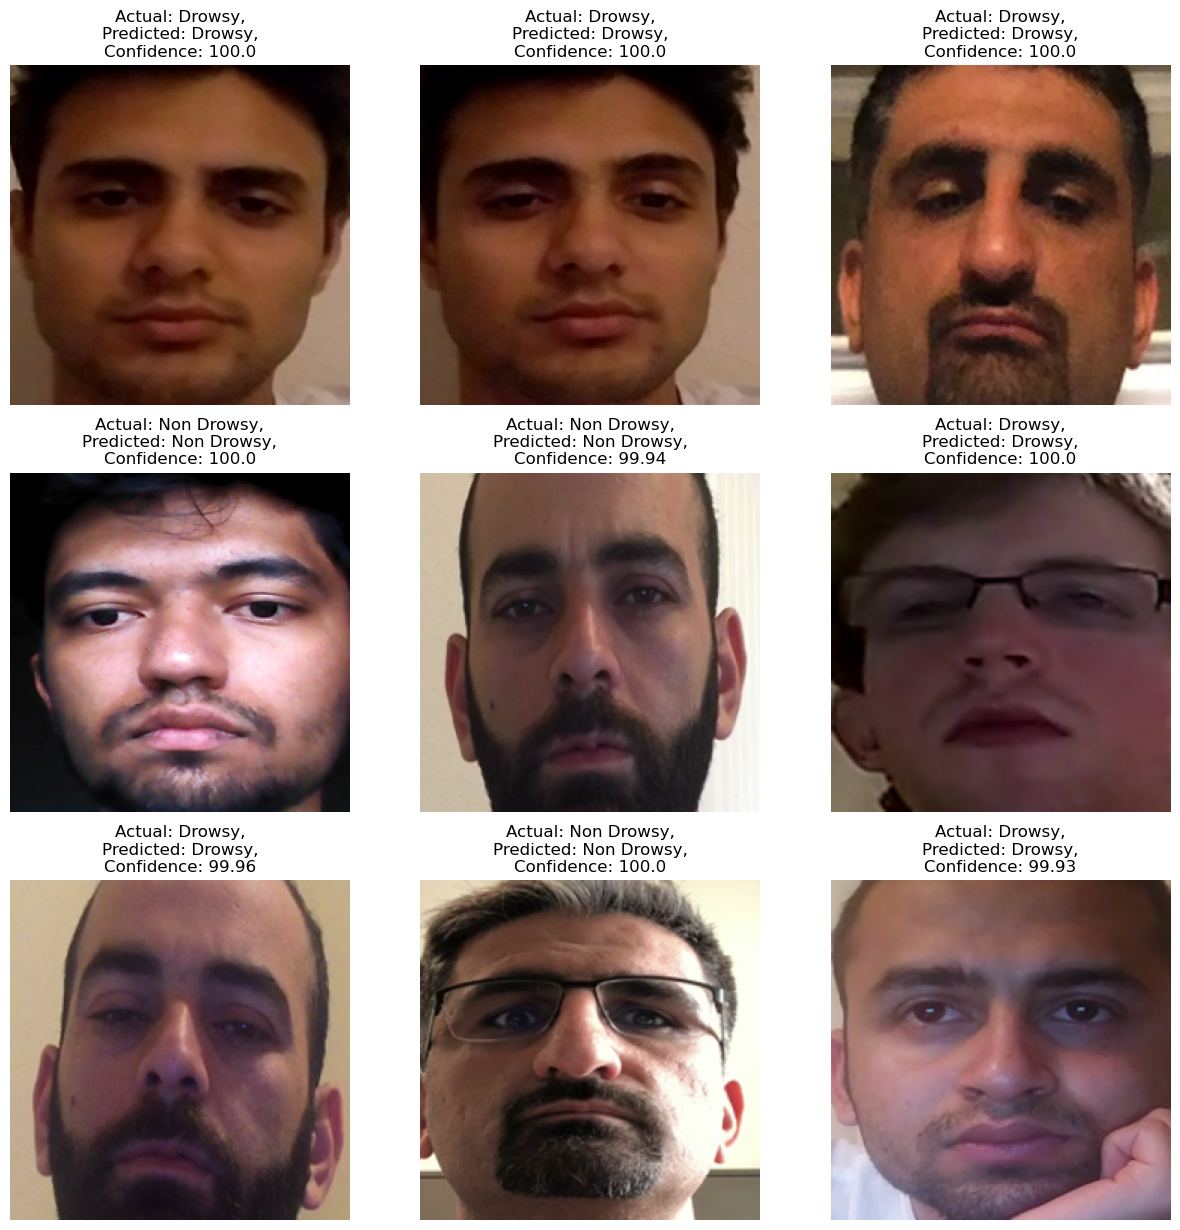

In [19]:
plt.figure(figsize=(15,15))
for images,labels in test_ds .take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy)
        actual_class= ddd_class[labels[i]]
        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence}")
        plt.axis('off')
        

In [16]:
model.save(r"C:\Users\ASUS\Desktop\Drowsy\Model")

INFO:tensorflow:Assets written to: C:\Users\ASUS\Desktop\Drowsy\Model\assets


INFO:tensorflow:Assets written to: C:\Users\ASUS\Desktop\Drowsy\Model\assets
